In [1]:
import os
import shutil
import pandas as pd

In [2]:
metadata = pd.read_csv(r"/Users/pedrosantos/Documents 2/Deep Learning/Projeto/rare_species 1/metadata.csv")
metadata

,rare_species_id,eol_content_id,eol_page_id,kingdom,phylum,family,file_path
0,75fd91cb-2881-41cd-88e6-de451e8b60e2,12853737,449393,animalia,mollusca,unionidae,mollusca_unionidae/12853737_449393_eol-full-si...
1,28c508bc-63ff-4e60-9c8f-1934367e1528,20969394,793083,animalia,chordata,geoemydidae,chordata_geoemydidae/20969394_793083_eol-full-...
2,00372441-588c-4af8-9665-29bee20822c0,28895411,319982,animalia,chordata,cryptobranchidae,chordata_cryptobranchidae/28895411_319982_eol-...
3,29cc6040-6af2-49ee-86ec-ab7d89793828,29658536,45510188,animalia,chordata,turdidae,chordata_turdidae/29658536_45510188_eol-full-s...
4,94004bff-3a33-4758-8125-bf72e6e57eab,21252576,7250886,animalia,chordata,indriidae,chordata_indriidae/21252576_7250886_eol-full-s...
...,...,...,...,...,...,...,...
11978,1fa96ea5-32fa-4a25-b8d2-fa99f6e2cb89,29734618,1011315,animalia,chordata,leporidae,chordata_leporidae/29734618_1011315_eol-full-s...
11979,628bf2b4-6ecc-4017-a8e6-4306849e0cfc,29972861,1056842,animalia,chordata,emydidae,chordata_emydidae/29972861_1056842_eol-full-si...
11980,0ecfdec9-b1cd-4d43-96fc-2f8889ec1ad9,30134195,52572074,animalia,chordata,dasyatidae,chordata_dasyatidae/30134195_52572074_eol-full...
11981,27fdb1e9-c5fb-459a-8b6a-6fb222b1c512,9474963,46559139,animalia,chordata,mustelidae,chordata_mustelidae/9474963_46559139_eol-full-...


In [3]:
metadata['family'] = metadata['family'].astype(str)  # Ensure it's a string
metadata['file_path'] = metadata['file_path'].astype(str)  # Ensure path is string

In [4]:
dataset_directory = r"/Users/pedrosantos/Documents 2/Deep Learning/Projeto/rare_species 1"

In [6]:
# Define output directories
output_base = r"/Users/pedrosantos/Documents 2/Deep Learning/Projeto/rare_species 1/dataset_split"
os.makedirs(output_base, exist_ok=True)
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(output_base, split), exist_ok=True)

In [7]:
# Stratified split at image level
from sklearn.model_selection import train_test_split

train_files, temp_files = train_test_split(metadata, test_size=0.3, stratify=metadata['family'], random_state=42)
val_files, test_files = train_test_split(temp_files, test_size=0.5, stratify=temp_files['family'], random_state=42)

In [12]:
def move_files(file_subset, split_name):
    for _, row in file_subset.iterrows():
        src_path = os.path.join(dataset_directory, row['file_path'])  # Construct full path
        dst_path = os.path.join(output_base, split_name, row['file_path'])
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)  # Ensure folder structure
        if os.path.exists(src_path):
            shutil.copy2(src_path, dst_path)
        else:
            print(f"Warning: {src_path} not found.")

# Move images to respective folders
move_files(train_files, 'train')
move_files(val_files, 'val')
move_files(test_files, 'test')

print("Dataset split completed!")


Dataset split completed!


#### Localizing Data

In [8]:
train_path = r"/Users/pedrosantos/Documents 2/Deep Learning/Projeto/rare_species 1/dataset_split/train"
valid_path = r"/Users/pedrosantos/Documents 2/Deep Learning/Projeto/rare_species 1/dataset_split/val"
test_path = r"/Users/pedrosantos/Documents 2/Deep Learning/Projeto/rare_species 1/dataset_split/test"

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

In [10]:
# Define ImageDataGenerator with preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,  # VGG16 preprocessing
    horizontal_flip=True,  # Add basic augmentation
    rotation_range=20
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input  # No augmentation for val/test
)

In [11]:
# Load images from directories
train_batches = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=(224, 224),
    batch_size=32,  # Adjust based on memory
    class_mode="categorical",  # Multi-class classification
    shuffle=True
)

val_batches = val_test_datagen.flow_from_directory(
    directory=valid_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False  # No shuffle for validation
)

test_batches = val_test_datagen.flow_from_directory(
    directory=test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False  # No shuffle for testing
)

# Print detected class labels
print(f"Class labels: {train_batches.class_indices}")

Found 8388 images belonging to 202 classes.
Found 1797 images belonging to 202 classes.
Found 1798 images belonging to 202 classes.
Class labels: {'arthropoda_apidae': 0, 'arthropoda_attelabidae': 1, 'arthropoda_carabidae': 2, 'arthropoda_cerambycidae': 3, 'arthropoda_coenagrionidae': 4, 'arthropoda_formicidae': 5, 'arthropoda_gomphidae': 6, 'arthropoda_lucanidae': 7, 'arthropoda_nymphalidae': 8, 'arthropoda_palinuridae': 9, 'arthropoda_papilionidae': 10, 'arthropoda_pisauridae': 11, 'arthropoda_platystictidae': 12, 'arthropoda_pseudophasmatidae': 13, 'arthropoda_tettigoniidae': 14, 'arthropoda_theraphosidae': 15, 'arthropoda_triopsidae': 16, 'chordata_accipitridae': 17, 'chordata_acipenseridae': 18, 'chordata_agamidae': 19, 'chordata_albulidae': 20, 'chordata_alcedinidae': 21, 'chordata_alligatoridae': 22, 'chordata_alopiidae': 23, 'chordata_ambystomatidae': 24, 'chordata_anatidae': 25, 'chordata_anguidae': 26, 'chordata_aotidae': 27, 'chordata_ardeidae': 28, 'chordata_arthroleptidae'

In [12]:
import matplotlib.pyplot as plt

In [13]:
imgs, labels = next(train_batches)

### this function will plot images in the form of a grid with 1 row and 10 columns where images are placed
def plt_images(images_arr):
    fig,axes = plt.subplots(1,10,figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr,axes):
        ax.imshow(img)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-115.635..138.48077].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-122.241875..150.24274].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..133.40909].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-110.50868..147.50198].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-119.48801..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-100.483376..142.982

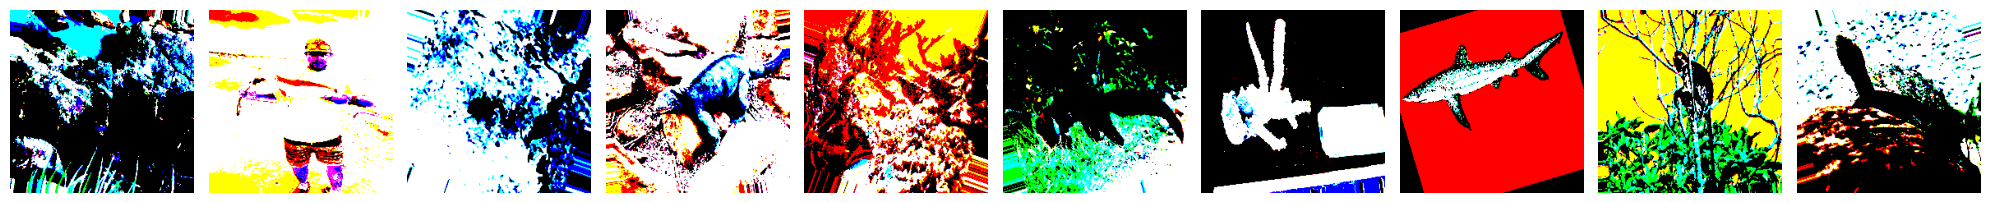

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [14]:
plt_images(imgs)
print(labels)

<hr>

## Training

#### Tensorboard for monitoring

In [15]:
root_logdir = os.path.expanduser("~/logs")  # Stores logs in home directory
os.makedirs(root_logdir, exist_ok=True)

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir,run_id)

In [16]:
run_logdir = get_run_logdir()

tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

### Model

In [17]:
# model building imports
from keras import Model, Sequential, Input

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers import LeakyReLU
from keras.ops import add
from keras.utils import to_categorical
# model training imports
from keras.optimizers import SGD
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy, AUC, F1Score
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler

In [ ]:
# model = Sequential([
#     Conv2D(filters=3*8, kernel_size=(3,3), activation="relu", padding="same", input_shape=(224,224,3)),
#     MaxPooling2D(pool_size=(2,2), strides=2),
#     Conv2D(filters=3*16, kernel_size=(3,3), activation="relu", padding="same"),
#     MaxPooling2D(pool_size=(2,2), strides=1),
#     Conv2D(filters=3*32, kernel_size=(3,3), activation="relu", padding="same"),
#     MaxPooling2D(pool_size=(2,2), strides=1),
#     Flatten(),
#     Dense(units=202, activation="softmax")
# ])

/opt/anaconda3/envs/DL/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

In [20]:
#model.fit(train_batches, validation_data=val_batches, epochs=50, verbose=2, callbacks=[tensorboard_cb])

In [18]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

In [19]:
vgg16_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [21]:
for layer in model.layers:
    layer.trainable = False

In [22]:
model.add(Dense((202), activation="softmax"))

In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 202)            │       827,594 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 135,088,138 (515.32 MB)

 Trainable params: 827,594 (3.16 MB)

 Non-trainable params: 134,260,544 (512.16 MB)

In [24]:
model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

In [26]:
model.fit(train_batches, validation_data=val_batches, epochs=2, verbose=2, callbacks=[tensorboard_cb])

/opt/anaconda3/envs/DL/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2


/opt/anaconda3/envs/DL/lib/python3.11/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


263/263 - 1001s - 4s/step - accuracy: 0.3852 - loss: 3.5598 - val_accuracy: 0.5031 - val_loss: 2.8962
Epoch 2/2
263/263 - 1020s - 4s/step - accuracy: 0.6643 - loss: 1.3892 - val_accuracy: 0.5281 - val_loss: 2.9535


#### Including batchNormalization; Dropout - Tweaking VGG16 Model

In [28]:
vgg16_model = tf.keras.applications.vgg16.VGG16()


In [29]:
vgg16_model.trainable = False

In [31]:
x = Flatten()(vgg16_model.output)
x = Dense(2096, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(2096, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(202, activation="softmax")(x)

model = Model(inputs=vgg16_model.input, outputs=x)
model.compile(optimizer=Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2096)           │     2,098,09

 Total params: 145,291,314 (554.24 MB)

 Trainable params: 6,925,386 (26.42 MB)

 Non-trainable params: 138,365,928 (527.82 MB)

In [33]:
model.fit(train_batches, validation_data=val_batches, epochs=15, verbose=2)

Epoch 1/15
263/263 - 996s - 4s/step - accuracy: 0.3708 - loss: 2.8315 - val_accuracy: 0.3856 - val_loss: 2.9227
Epoch 2/15
263/263 - 963s - 4s/step - accuracy: 0.3748 - loss: 2.7157 - val_accuracy: 0.3845 - val_loss: 2.8746
Epoch 3/15
263/263 - 981s - 4s/step - accuracy: 0.3857 - loss: 2.6379 - val_accuracy: 0.3918 - val_loss: 2.8096
Epoch 4/15
263/263 - 993s - 4s/step - accuracy: 0.4118 - loss: 2.5123 - val_accuracy: 0.3934 - val_loss: 2.8331
Epoch 5/15
263/263 - 1008s - 4s/step - accuracy: 0.4070 - loss: 2.4706 - val_accuracy: 0.4040 - val_loss: 2.8203
Epoch 6/15
263/263 - 3790s - 14s/step - accuracy: 0.4244 - loss: 2.3991 - val_accuracy: 0.3996 - val_loss: 2.8120
Epoch 7/15
263/263 - 1022s - 4s/step - accuracy: 0.4307 - loss: 2.3382 - val_accuracy: 0.4029 - val_loss: 2.8295
Epoch 8/15
263/263 - 991s - 4s/step - accuracy: 0.4474 - loss: 2.2488 - val_accuracy: 0.4018 - val_loss: 2.8345
Epoch 9/15
263/263 - 991s - 4s/step - accuracy: 0.4441 - loss: 2.2415 - val_accuracy: 0.4124 - val_l

#### It seems that we have limited far too much the model's capability. Lets do another try:

In [41]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Load VGG16 WITHOUT top layers
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze convolutional base
base_model.trainable = False

# Get model input
inputs = base_model.input
x = base_model.output  # Extract output from last convolutional layer

# ✅ Add BatchNormalization after each convolutional block
x = BatchNormalization()(x)  # Add BatchNorm before Flatten

# ✅ Flatten output of convolutional base
x = Flatten()(x)

# ✅ Fully Connected Layers with Dropout and BatchNorm
x = Dense(3000, activation="relu")(x)  # Reduced from 4096 to 3000
x = BatchNormalization()(x)  # Batch Norm after fc1
x = Dense(3000, activation="relu")(x)  # Reduced from 4096 to 3000
x = BatchNormalization()(x)  # Batch Norm after fc2
x = Dropout(0.2)(x)  # Dropout after fc2

# ✅ Output layer for 202 classes
x = Dense(202, activation="softmax")(x)

# ✅ Create the final model
model = Model(inputs=inputs, outputs=x)

# ✅ Compile
model.compile(optimizer=Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])

# ✅ Print model summary
model.summary()


Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 7, 7, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 3000)           │    75,267,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 3000)           │        12,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 3000)           │     9,003,00

 Total params: 99,616,938 (380.01 MB)

 Trainable params: 84,889,226 (323.83 MB)

 Non-trainable params: 14,727,712 (56.18 MB)

In [42]:
model.fit(train_batches, validation_data=val_batches, epochs=15, verbose=2)

Epoch 1/15


/opt/anaconda3/envs/DL/lib/python3.11/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


263/263 - 1044s - 4s/step - accuracy: 0.2952 - loss: 3.6443 - val_accuracy: 0.4686 - val_loss: 2.5377
Epoch 2/15
263/263 - 1022s - 4s/step - accuracy: 0.6665 - loss: 1.4024 - val_accuracy: 0.5225 - val_loss: 2.1362
Epoch 3/15
263/263 - 1021s - 4s/step - accuracy: 0.7936 - loss: 0.8310 - val_accuracy: 0.5531 - val_loss: 2.0259
Epoch 4/15
263/263 - 2009s - 8s/step - accuracy: 0.8569 - loss: 0.5725 - val_accuracy: 0.5498 - val_loss: 2.0398
Epoch 5/15
263/263 - 1045s - 4s/step - accuracy: 0.9003 - loss: 0.3910 - val_accuracy: 0.5598 - val_loss: 1.9674
Epoch 6/15


KeyboardInterrupt: 

In [34]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6007

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 2594), started 7:00:41 ago. (Use '!kill 2594' to kill it.)